# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

```bash
pip install networkx==2.3
pip install matplotlib==2.2.3
```

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import networkx as nx
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from networkx.algorithms import bipartite

import warnings
warnings.filterwarnings("ignore")


# Recommended to use Python 3.6 for StellarGraph
# !pip install chardet

from sklearn.manifold import TSNE

from stellargraph import StellarGraph
from stellargraph.data import UniformRandomMetaPathWalk

print(f"networkx verion is '2.3' : {nx.__version__ == '2.3'}")

networkx verion is '2.3' : True


In [2]:
data = pd.read_csv('movie_actor_network.csv', index_col = False, names = ['movie', 'actor'])

In [3]:
edges = [tuple(x) for x in data.values.tolist()]

In [4]:
B = nx.Graph()

B.add_nodes_from(data['movie'].unique(), bipartite = 0, label = 'movie')
B.add_nodes_from(data['actor'].unique(), bipartite = 1, label = 'actor')
B.add_edges_from(edges, label = 'acted')

In [5]:
'''
connected_component_subgraphs was removed from networkx 2.4
So using networkx==2.3

-------------------------------------------------------------

IF networkx version in 2.5.1 OR > 2.5
https://stackoverflow.com/a/65264264

A = list(B.subgraph(c) for c in nx.connected_components(B))[0]
'''

A = list(nx.connected_component_subgraphs(B))[0]

In [6]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


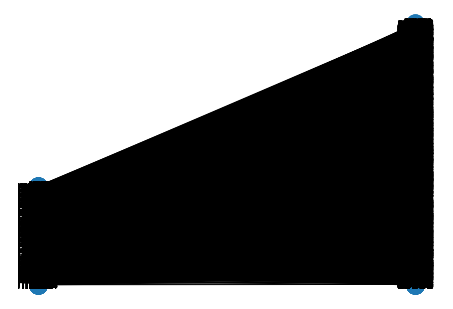

In [7]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [8]:
movies = []
actors = []

for i in A.nodes():
    
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
        
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [9]:
'''
This code is not working in Matplotlib 3.5.1
So changed into matplotlib 2.1.1

https://stackoverflow.com/a/53936824
pip install matplotlib==2.1.1
'''


# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [["movie", "actor", "movie"],
             ["actor", "movie", "actor"]]

walks = rw.run(nodes = list(A.nodes()), # root nodes
               length = 100,  # maximum length of a random walk
               n = 1,        # number of random walks per root node 
               metapaths = metapaths)

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [10]:
from gensim.models import Word2Vec

'''
https://stackoverflow.com/a/70208469

model = Word2Vec(walks, size = 128, window = 5)

`size` parameter was renamed into `vector_size` in new Word2Vec
'''

model = Word2Vec(walks, vector_size = 128, window = 5)

In [11]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [12]:
# Retrieve node embeddings and corresponding subjects

''' ORIGINAL
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

     ERROR
The index2word attribute has been replaced by index_to_key since Gensim 4.0.0.
'''

node_ids = model.wv.index_to_key  # list of node IDs

node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality

node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

print(f'Node ID     : {node_ids[: 10]}')
print(f'\nNode Target : {node_targets[: 10]}')

Node ID     : ['a973', 'a967', 'a964', 'a1731', 'a970', 'a969', 'a1028', 'a965', 'a1003', 'a1057']

Node Target : ['actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor']


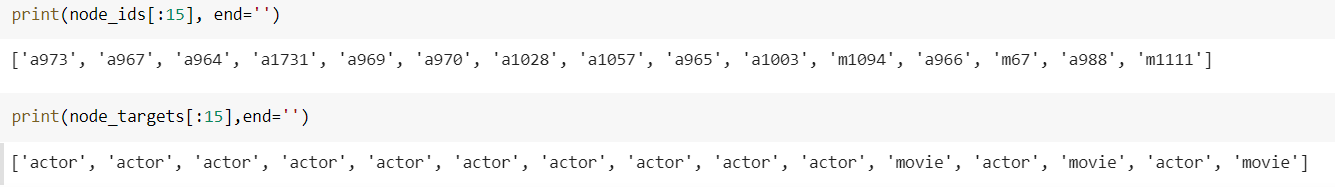

In [13]:
def data_split(node_ids_, node_targets_, node_embeddings_):
    
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    
    actor_node, movie_node = [], []
    actor_embedding, movie_embedding = [], []
    
    for idx, val in enumerate(node_ids_):
        
        if node_targets_[idx] == 'actor':
            actor_node.append(val)
        
        if node_targets_[idx] == 'movie':
            movie_node.append(val)

            
    for idx, val in enumerate(node_embeddings_):
        
        if node_targets_[idx] == 'actor':
            actor_embedding.append(val)
        
        if node_targets_[idx] == 'movie':
            movie_embedding.append(val)
            
    return actor_node, movie_node, actor_embedding, movie_embedding

In [14]:
actor_nodes, movie_nodes, actor_embeddings, movie_embeddings = \
                                                data_split(node_ids, node_targets, node_embeddings)

**<font color='red'>Grader function - 1</font>**

In [15]:
def grader_actors(data):

    assert(len(data) == 3411)
    return True

grader_actors(actor_nodes)

True

**<font color='red'>Grader function - 2</font>**

In [16]:
def grader_movies(data):
    
    assert(len(data) == 1292)
    return True

grader_movies(movie_nodes)

True

**<font color='blue'>Calculating cost 1</font>**

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [17]:
def cost1(graph, number_of_clusters):
    
    '''In this function, we will calculate cost1'''
    
    total_nodes = graph.number_of_nodes()
    
    max_no_nodes = max([x.number_of_nodes() for x in list(nx.connected_component_subgraphs(graph))])
    
    cost1 = ((1/number_of_clusters) * (max_no_nodes/total_nodes))

    return cost1

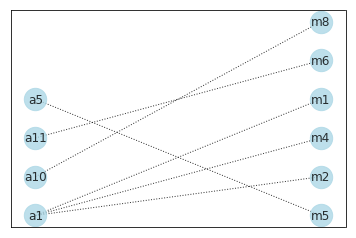

In [18]:
graded_graph= nx.Graph()

graded_graph.add_nodes_from(['a1', 'a5', 'a10', 'a11'], bipartite = 0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1', 'm2', 'm4', 'm6', 'm5', 'm8'], bipartite = 1)
graded_graph.add_edges_from([('a1', 'm1'), ('a1', 'm2'), ('a1', 'm4'), ('a11', 'm6'), \
                                                             ('a5', 'm5'), ('a10', 'm8')])

l = {'a1', 'a5', 'a10', 'a11'}
r = {'m1', 'm2', 'm4', 'm6', 'm5', 'm8'}

pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))

nx.draw_networkx(graded_graph, pos = pos, with_labels = True, node_color = 'lightblue', \
                                                         alpha = 0.8, style = 'dotted', node_size = 500)

**<font color='red'>Grader function - 3</font>**

In [19]:
graded_cost1 = cost1(graded_graph, 3)

def grader_cost1(data):
    
    assert(data == ((1/3) * (4/10))) # 1/3 is number of clusters
    return True

grader_cost1(graded_cost1)

True

**<font color='blue'>Calculating cost2</font>**

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [20]:
def cost2(graph, number_of_clusters):
    
    '''In this function, we will calculate cost1'''
    
    movie_count = 0
        
    total_no_of_edges = np.array([x.number_of_edges() for x in \
                                list(nx.connected_component_subgraphs(graded_graph))]).sum()

    for node in graded_graph.degree():

        if 'a' in node[0]:
            movie_count += node[1]

    cost2 = (1/number_of_clusters) * (total_no_of_edges/movie_count)
    
    return cost2

**<font color='red'>Grader function - 4</font>**

In [21]:
graded_cost2 = cost2(graded_graph, 3)

def grader_cost2(data):
    
    assert(data == ((1/3) * (6/6))) # 1/3 is number of clusters
    return True

grader_cost2(graded_cost2)

True

<font color='blue'>Grouping similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

In [22]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans
# https://www.geeksforgeeks.org/ego-graph-using-networkx-in-python/

n_cluster = [3, 5, 10, 30, 50, 100, 200, 500]

cost_values_a = []
for cluster in tqdm(n_cluster):
    
    kmeans_actor = KMeans(n_clusters = cluster, n_jobs = -1)
    kmeans_actor.fit(actor_embeddings)
    labels = kmeans_actor.labels_

    act_label_dict = dict(zip(actor_nodes, labels))

    cost_1 = 0
    cost_2 = 0

#     for label in tqdm(labels, desc = 'labels'):
    for label in set(labels):
        act_node = [key for key, value in act_label_dict.items() if value == label]
        graph = nx.Graph()

        for node in act_node:
            sub_graph = nx.ego_graph(A, node)
            graph.add_nodes_from(sub_graph.nodes)
            graph.add_edges_from(sub_graph.edges())
        cost_1 += cost1(graph, cluster)
        cost_2 += cost2(graph, cluster)

    cost_error = cost_1 * cost_2
    cost_values_a.append(cost_error)

for clus, cost in zip(n_cluster, cost_values_a):
    print(f'Cost on cluster {clus}\t: {round(cost, 3)}')

100%|██████████| 8/8 [01:23<00:00, 10.47s/it]

Cost on cluster 3	: 0.912
Cost on cluster 5	: 0.897
Cost on cluster 10	: 0.886
Cost on cluster 30	: 0.831
Cost on cluster 50	: 0.883
Cost on cluster 100	: 0.849
Cost on cluster 200	: 0.852
Cost on cluster 500	: 0.9


In [23]:
best_cluster_a = n_cluster[cost_values_a.index(max(cost_values_a))]
print(f'Best Cluster is : {best_cluster_a}')

kmeans_a = KMeans(n_clusters = best_cluster_a)
kmeans_a.fit(actor_embeddings)

Best Cluster is : 3


KMeans(n_clusters=3)

<font color='blue'>Displaying similar actor clusters</font>

In [24]:
transform = TSNE
trans_ = transform(n_components = 2) # 2D plane
act_embedding_2d = trans_.fit_transform(actor_embeddings)

In [25]:
label_map = np.unique(kmeans_a.labels_)
node_colours = [ label_map[target] for target in list(kmeans_a.labels_)]

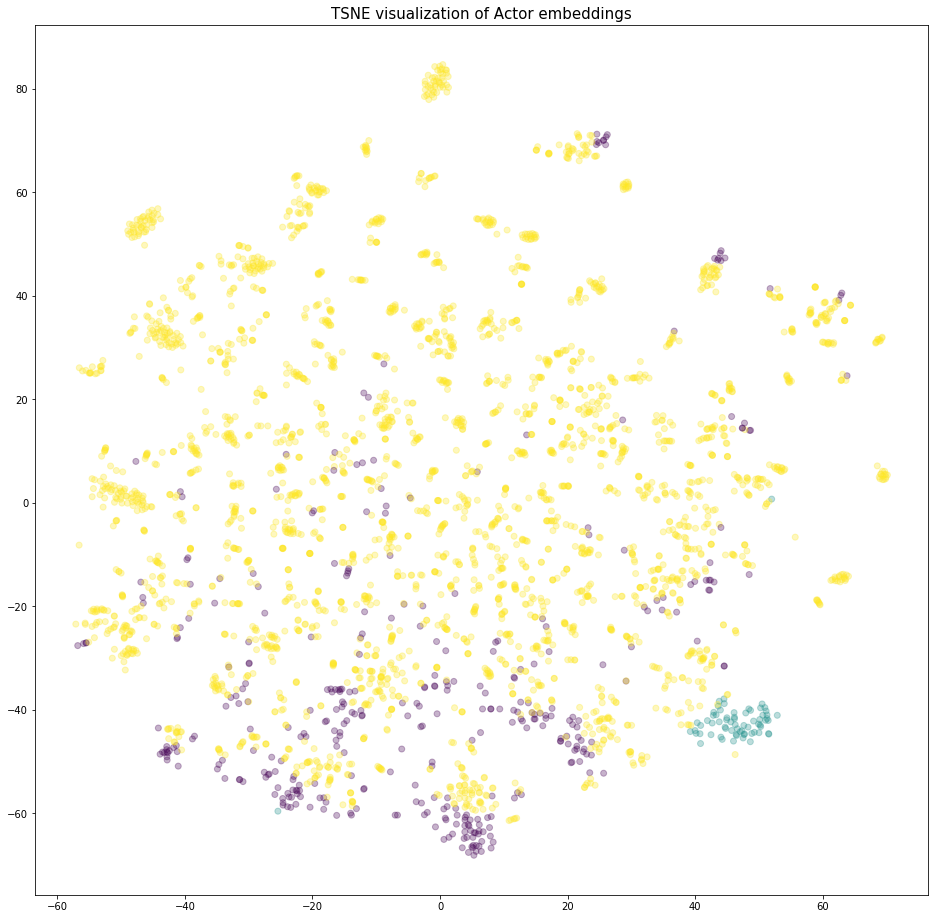

In [26]:
plt.figure(figsize=(16,16))
plt.scatter(act_embedding_2d[:,0], act_embedding_2d[:,1], alpha = 0.3,
            c = node_colours)
plt.title('TSNE visualization of Actor embeddings', size = 15)
plt.show()

<font color='blue'>Grouping similar movies</font>

In [27]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans
# https://www.geeksforgeeks.org/ego-graph-using-networkx-in-python/

cost_values_mov = []
for cluster in tqdm(n_cluster):
    
    kmeans_movie = KMeans(n_clusters = cluster, n_jobs = -1)
    kmeans_movie.fit(movie_embeddings)
    labels = kmeans_movie.labels_

    mov_label_dict = dict(zip(movie_nodes, labels))

    cost_1 = 0
    cost_2 = 0

#     for label in tqdm(labels, desc = 'labels'):
    for label in set(labels):
        mov_node = [key for key, value in mov_label_dict.items() if value == label]
        graph = nx.Graph()

        for node in mov_node:
            sub_graph = nx.ego_graph(A, node)
            graph.add_nodes_from(sub_graph.nodes)
            graph.add_edges_from(sub_graph.edges())
        cost_1 += cost1(graph, cluster)
        cost_2 += cost2(graph, cluster)

    cost_error = cost_1 * cost_2
    cost_values_mov.append(cost_error)

for clus, cost in zip(n_cluster, cost_values_mov):
    print(f'Cost on cluster {clus}\t: {round(cost, 3)}')

100%|██████████| 8/8 [00:29<00:00,  3.65s/it]

Cost on cluster 3	: 0.98
Cost on cluster 5	: 0.971
Cost on cluster 10	: 0.933
Cost on cluster 30	: 0.939
Cost on cluster 50	: 0.97
Cost on cluster 100	: 0.985
Cost on cluster 200	: 0.987
Cost on cluster 500	: 0.994


In [28]:
best_cluster_m = n_cluster[cost_values_mov.index(max(cost_values_mov))]
print(f'Best Cluster is : {best_cluster_m}')

kmeans_m = KMeans(n_clusters = best_cluster_m)
kmeans_m.fit(movie_embeddings)

Best Cluster is : 500


KMeans(n_clusters=500)

<font color='blue'>Displaying similar movie clusters</font>

In [29]:
transform = TSNE
trans_ = transform(n_components = 2) # 2D plane
mov_embedding_2d = trans_.fit_transform(movie_embeddings)

In [30]:
label_map = np.unique(kmeans_m.labels_)
node_colours = [ label_map[target] for target in list(kmeans_m.labels_)]

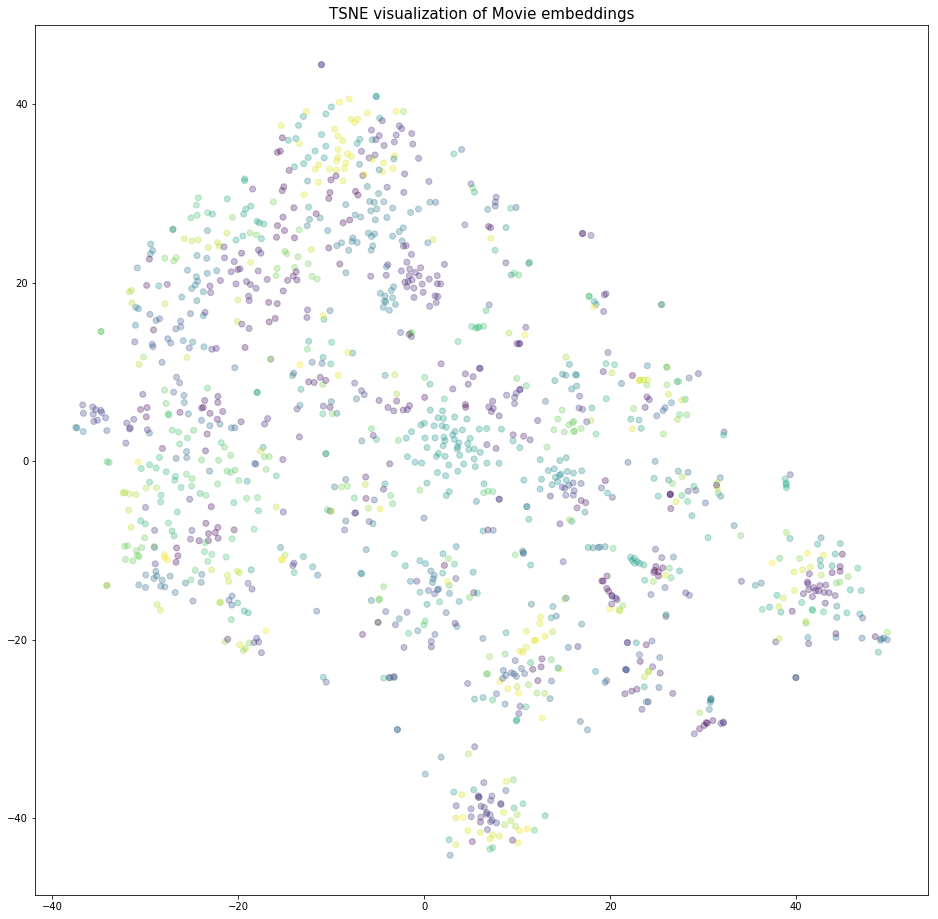

In [31]:
plt.figure(figsize=(16,16))
plt.scatter(mov_embedding_2d[:,0], mov_embedding_2d[:,1], alpha = 0.3,
            c = node_colours)
plt.title('TSNE visualization of Movie embeddings', size = 15)
plt.show()